# HW 1 Парсинг данных

## Получение датасета 

In [2]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек
import time          # Библиотека для времени

import warnings
warnings.filterwarnings("ignore")


In [102]:
#!pip install pytest-cov
#!pip install pytest-filter-subpackage
#!pip install fake_useragent

In [2]:
# подгрузим один из методов этой библиотеки
from fake_useragent import UserAgent

In [3]:
UserAgent().chrome

'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'

In [4]:
from bs4 import BeautifulSoup

Собирем данные об отзывах о фильмах на сайте  https://irecommend.ru/

In [5]:
page_link = 'https://irecommend.ru/content/passazhiry-passengers-0'

In [6]:
response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
response

<Response [200]>

In [7]:
html = response.content

In [8]:
soup = BeautifulSoup(html, 'html.parser')

Ищем информацию с комментарием к фильму и оценкой в виде звезд (от 1 до 5)

In [9]:
views = soup.findAll(attrs={'class':'smTeaser'})[1]
views

<div class="smTeaser woProduct plate reviews-list-item teaser-item" data-nid="3602662" data-photos-count="12" data-product-id="3601788" data-type="1" data-vid="10700889">
<div class="authorAndPhoto">
<div class="authorSpace">
<div class="half1">
<div class="authorPhoto"><div class="picture">
<a href="/users/vashamasha" title="Информация о пользователе."><img alt="Best Regards аватар" class="lazy lazy-loader" data-original="https://cdn-irec.r-99.com/sites/default/files/imagecache/60i/pictures/picture-82758-ed7bb.jpg" src="/themes/irecommend_new/images/ajax-loader.gif" title="Информация о пользователе."/></a></div>
</div>
<div>
<div class="starsRating"><div class="fivestarWidgetStatic fivestarWidgetStatic-vote fivestarWidgetStatic-5"><div class="star"><div class="on"></div></div><div class="star"><div class="off"></div></div><div class="star"><div class="off"></div></div><div class="star"><div class="off"></div></div><div class="star"><div class="off"></div></div></div></div>
<div class=

Ищем класс с комметарием

In [10]:
reviewTitle = views.find(attrs={'class':'reviewTitle'})
reviewTitle

<div class="reviewTitle"><a href="/content/davno-ne-videla-takikh-bredovykh-filmov-passazhiry-2016-otzyv-na-fantasticheskuyu-melodramu">Давно не видела таких бредовых фильмов. "Пассажиры" 2016 отзыв на фантастическую мелодраму. Космос тут просто мимо проплывал... Обновлено 25.12</a></div>

Извлекаем комментарий

In [11]:
comment = reviewTitle.a.string
print(comment)

Давно не видела таких бредовых фильмов. "Пассажиры" 2016 отзыв на фантастическую мелодраму. Космос тут просто мимо проплывал... Обновлено 25.12


Ищем класс с рейтингом

In [12]:
starsRating = views.find(attrs={'class':'starsRating'})
starsRating

<div class="starsRating"><div class="fivestarWidgetStatic fivestarWidgetStatic-vote fivestarWidgetStatic-5"><div class="star"><div class="on"></div></div><div class="star"><div class="off"></div></div><div class="star"><div class="off"></div></div><div class="star"><div class="off"></div></div><div class="star"><div class="off"></div></div></div></div>

Подсчитываем количество звезд (поставлена - class='on', нет - class='off')

In [13]:
rating = len(starsRating.findAll(attrs={'class':'on'}))
rating

1

Пишем функцию

In [15]:
def getText(body):
    """
        Возвращает комментарий и оценку
    """
    reviewTitle = body.find(attrs={'class':'reviewTitle'})
    comment = reviewTitle.a.string
    
    #if comment:
    #    comment = comment.split('\n')
    #    comment = " ".join(comment).strip()
    #else:
    #    comment = ""
    
    starsRating = body.find(attrs={'class':'starsRating'})
    
    rating = len(starsRating.findAll(attrs={'class':'on'}))

    return {'Comment': comment, 'Rating':rating}    

In [16]:
getText(views)

{'Comment': 'Давно не видела таких бредовых фильмов. "Пассажиры" 2016 отзыв на фантастическую мелодраму. Космос тут просто мимо проплывал... Обновлено 25.12',
 'Rating': 1}

In [17]:
def getPageData(url, page_number):
    # составляем ссылку на страницу поиска
    if page_number == 0:
        page_link = url
    else:
        page_link = '{}?page={}'.format(url,page_number)
    
    print(page_link)

    # запрашиваем данные по ней
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})

    if not response.ok:
        # если сервер нам отказал, вернем пустой лист для текущей страницы
        return []

    # получаем содержимое страницы и переводим в суп
    html = response.content
    soup = BeautifulSoup(html,'html.parser')
    
    return soup.findAll(attrs={'class':'smTeaser'})

In [18]:
len(getPageData('https://irecommend.ru/content/passazhiry-passengers-0', 4))

https://irecommend.ru/content/passazhiry-passengers-0?page=4


36

In [19]:
# Функция, которая собирает данные и сохраняет в DataFrame
sleep = 15 
def appendData(url, df):
    for page_number in range(1000):
        list = getPageData(url, page_number)

        for body in list:
            data_row = getText(body)
            df = df.append(data_row, ignore_index=True).dropna(axis = 1)

        print(len(df))    
        # По 50 комментариев на страницу, если меньше, то завершаем, после обработки
        if len(list) < 50:
            break
        time.sleep(sleep)    
    return df        

In [20]:
url = 'https://irecommend.ru/content/passazhiry-passengers-0'
df = pd.DataFrame(columns=['Comment',  'Rating'])
df = appendData(url, df)

https://irecommend.ru/content/passazhiry-passengers-0
50
https://irecommend.ru/content/passazhiry-passengers-0?page=1
100
https://irecommend.ru/content/passazhiry-passengers-0?page=2
150
https://irecommend.ru/content/passazhiry-passengers-0?page=3
186


In [21]:
df

,Comment,Rating
0,"""Перестань волноваться о том, что не можешь ко...",5
1,"Давно не видела таких бредовых фильмов. ""Пасса...",1
2,"Двое пассажиров космического корабля, просыпаю...",4
3,"Человеку нужен человек. Если нельзя, но очень ...",5
4,"Фильм, который я смотрела уже более 3 раз и го...",5
...,...,...
181,Фильм на один раз,4
182,Однозначно понравилось!! Давно так не было!,5
183,"Можно чуть меньше романтики было, а в целом ко...",4
184,"Яркий, но одноразовый",4


### Собираем больше данных (по нескольким фильмам)

In [225]:
pages = [
    'https://irecommend.ru/content/passazhiry-passengers-0',
    'https://irecommend.ru/content/zelenaya-milya',
    'https://irecommend.ru/content/2012',
    'https://irecommend.ru/content/neprikasaemye-intouchables',
    'https://irecommend.ru/content/ivan-vasilevich-menyaet-professiyu',
    'https://irecommend.ru/content/dzhoker-0',
    'https://irecommend.ru/content/kruella-cruella-2021-film',
    'https://irecommend.ru/content/gordost-i-predubezhdenie',
    'https://irecommend.ru/content/my-millery',
    'https://irecommend.ru/content/vremya-time',
    'https://irecommend.ru/content/bogemskaya-rapsodiya',
    'https://irecommend.ru/content/dyavol-nosit-prada-0',
    'https://irecommend.ru/content/t-34',
    'https://irecommend.ru/content/interstellar',
    'https://irecommend.ru/content/dostat-nozhi-2019-film',
    'https://irecommend.ru/content/tri-metra-nad-nebom',
    'https://irecommend.ru/content/volk-s-uoll-strit-2013'
]

In [171]:
# Добавлял данные, чтобы увеличить объем данных
pages = [
    #'https://irecommend.ru/content/sinister',
    #'https://irecommend.ru/content/vremya-old-2021-film',
    #'https://irecommend.ru/content/dukhless',
    #'https://irecommend.ru/content/anna-karenina-2012g',
    #'https://irecommend.ru/content/sumerki',
    #'https://irecommend.ru/content/devushka-v-poezde-girl-train',
    #'https://irecommend.ru/content/moskva-slezam-ne-verit',
    #'https://irecommend.ru/content/vek-adelin',
    #'https://irecommend.ru/content/begushchii-v-labirinte-maze-runner',
    #'https://irecommend.ru/content/zarnitsa-2021-film',
    #'https://irecommend.ru/content/fantasticheskie-tvari-tainy-dambldora-fantastic-beasts-secrets-dumbledore-2022-film',
    #'https://irecommend.ru/content/odnoi-bezumnoi-nochyu-2023-film',
    #'https://irecommend.ru/content/epitsentr-buri-2023-film',
    #'https://irecommend.ru/content/eskortnitsa-2023-film',
    #'https://irecommend.ru/content/uglovaya-komnata-1962-film',
    #'https://irecommend.ru/content/v-efire-line-2022-film',
    #'https://irecommend.ru/content/smotret-v-obe-storony-look-both-ways-2022-film',
    #'https://irecommend.ru/content/yura-dvornik-2023-film',
    #'https://irecommend.ru/content/anon-anon-0',
    #'https://irecommend.ru/content/za-palycha-2023-film',
    #'https://irecommend.ru/content/raiskoe-shosse-2022-film',
    #'https://irecommend.ru/content/illyuziya-pobega-2023-film',
    #'https://irecommend.ru/content/skandal-2019-film-0',
    #'https://irecommend.ru/content/proniknovenie-2022-film',
    #'https://irecommend.ru/content/cheburashka-2022-film-0',
    #'https://irecommend.ru/content/groza-2020-film',
    #'https://irecommend.ru/content/13-minut-2021-film',
    #'https://irecommend.ru/content/temnyi-mir',
    #'https://irecommend.ru/content/malefisenta-vladychitsa-tmy-maleficent-mistress-evil'
]

In [172]:
full_df = pd.DataFrame(columns=['Comment',  'Rating'])
for url in pages:
    full_df = appendData(url, full_df)
    time.sleep(sleep)  

https://irecommend.ru/content/illyuziya-pobega-2023-film
9
https://irecommend.ru/content/skandal-2019-film-0
26
https://irecommend.ru/content/proniknovenie-2022-film
31
https://irecommend.ru/content/cheburashka-2022-film-0
81
https://irecommend.ru/content/cheburashka-2022-film-0?page=1
131
https://irecommend.ru/content/cheburashka-2022-film-0?page=2
181
https://irecommend.ru/content/cheburashka-2022-film-0?page=3
231
https://irecommend.ru/content/cheburashka-2022-film-0?page=4
281
https://irecommend.ru/content/cheburashka-2022-film-0?page=5
331
https://irecommend.ru/content/cheburashka-2022-film-0?page=6
381
https://irecommend.ru/content/cheburashka-2022-film-0?page=7
386
https://irecommend.ru/content/groza-2020-film
396
https://irecommend.ru/content/13-minut-2021-film
405
https://irecommend.ru/content/temnyi-mir
434
https://irecommend.ru/content/malefisenta-vladychitsa-tmy-maleficent-mistress-evil
484
https://irecommend.ru/content/malefisenta-vladychitsa-tmy-maleficent-mistress-evil?p

In [217]:
full_df

,Comment,Rating
0,"""Перестань волноваться о том, что не можешь ко...",5
1,"Двое пассажиров космического корабля, просыпаю...",4
2,"Давно не видела таких бредовых фильмов. ""Пасса...",1
3,"Человеку нужен человек. Если нельзя, но очень ...",5
4,Неплохая вариация на тему космоса и одиночества,4
...,...,...
6742,"Фильм, который стоит посмотреть!",5
6743,Завораживающий - breathtaking!,5
6744,"Малефисента-2 - сиквел удался, или мои впечатл...",4
6745,Вау!,5


In [176]:
full_df['Comment'] = full_df['Comment'].astype( str )
full_df['Rating'] = full_df['Rating'].astype(int)

Сохраняем данные в файл, чтобы не потерять

In [179]:
pd.to_pickle(full_df, "data.pkl")

In [4]:
df = pd.read_pickle("data.pkl")
df

,Comment,Rating
0,"""Перестань волноваться о том, что не можешь ко...",5
1,"Двое пассажиров космического корабля, просыпаю...",4
2,"Давно не видела таких бредовых фильмов. ""Пасса...",1
3,"Человеку нужен человек. Если нельзя, но очень ...",5
4,Неплохая вариация на тему космоса и одиночества,4
...,...,...
6742,"Фильм, который стоит посмотреть!",5
6743,Завораживающий - breathtaking!,5
6744,"Малефисента-2 - сиквел удался, или мои впечатл...",4
6745,Вау!,5


## Анализ данных

### Распределение по оценкам

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Преобразуем dataframe в json
data = df.to_json(orient='records')
data = json.loads(data)

In [7]:
data[0]

{'Comment': '"Перестань волноваться о том, что не можешь контролировать, просто живи" - пожалуй, это самый лучший жизненный совет|Робинзонада в космосе✨🌙|Один из моих любимых фильмов. Когда мне грустно, я включаю "Пассажиры".',
 'Rating': 5}

In [8]:
from collections import Counter
print(len(data))
Counter([x['Rating'] for x in data]).most_common()

6747


[(5, 4469), (4, 1066), (3, 609), (2, 329), (1, 274)]

### Предобработка текста

Для подсчета статистики встречаемости слов удаляем стоп-слова, пунктуацию, смайлики и т.д.

In [9]:
import nltk   # Natural Language Toolkit
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tima-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import re
regex = re.compile(r'[А-Яа-яA-zёЁ]+')


def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text)).lower()
    except:
        return ""

def process_data(data):
    texts = []
    targets = []

    # поочередно проходим по всем новостям в списке
    for item in tqdm(data):

        text_lower = words_only(item['Comment']) # оставим только слова
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем текст на слова

        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in stop_words and not word.isnumeric())]

        texts.append(tokens) # добавляем в предобработанный список

    return texts

In [11]:
y = [item['Rating'] for item in data]
texts = process_data(data)

100%|███████████████████████████████████████████████████████████████████████████| 6747/6747 [00:00<00:00, 51077.85it/s]


In [12]:
# example
i = 1
print("Rating: ", y[i])
print("Comment: ", texts[i])

Rating:  4
Comment:  ['двое', 'пассажиров', 'космического', 'корабля', 'просыпаются', 'раньше', 'положенного', 'лет', 'романтическая', 'история', 'космическом', 'корабле']


### Нормализация слов

In [13]:
# загружаем библиотеку для лемматизации
import pymorphy2 # Морфологический анализатор

# инициализируем лемматизатор :)
morph = pymorphy2.MorphAnalyzer()

In [14]:
i = 1
for aword in texts[i]:
    aword_norm = morph.parse(aword)[0].normal_form
    print("Исходное слово: %s\tЛемматизированное: %s" % (aword, aword_norm))

Исходное слово: двое	Лемматизированное: двое
Исходное слово: пассажиров	Лемматизированное: пассажир
Исходное слово: космического	Лемматизированное: космический
Исходное слово: корабля	Лемматизированное: корабль
Исходное слово: просыпаются	Лемматизированное: просыпаться
Исходное слово: раньше	Лемматизированное: ранний
Исходное слово: положенного	Лемматизированное: положить
Исходное слово: лет	Лемматизированное: год
Исходное слово: романтическая	Лемматизированное: романтический
Исходное слово: история	Лемматизированное: история
Исходное слово: космическом	Лемматизированное: космический
Исходное слово: корабле	Лемматизированное: корабль


In [15]:
# применяем лемматизацию ко всем текстам
text_normal = []
text_tokens = []
for i in range(len(texts)):           # tqdm_notebook создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
    text_normal.append(' '.join(text_lemmatized))               # объединяем все слова в одну строку через пробел
    text_tokens.append(text_lemmatized)

In [16]:
# example
i = 1
print("Rating: ", y[i])
print("Comment: ", text_normal[i])
print("Tokens:", text_tokens[i])

Rating:  4
Comment:  двое пассажир космический корабль просыпаться ранний положить год романтический история космический корабль
Tokens: ['двое', 'пассажир', 'космический', 'корабль', 'просыпаться', 'ранний', 'положить', 'год', 'романтический', 'история', 'космический', 'корабль']


In [17]:
# Токенизируем все слова

text = nltk.Text(np.concatenate(text_tokens))

In [18]:
print(len(text))
text

34424


<Text: перестать волноваться мочь контролировать просто живить пожалуй это...>

### Подсчёт статистики встречаемости слов

In [103]:
from nltk.probability import FreqDist
fdist = FreqDist(text)

In [104]:
fdist

FreqDist({'фильм': 2656, 'хороший': 564, 'смотреть': 426, 'который': 409, 'это': 393, 'очень': 337, 'просмотр': 310, 'жизнь': 291, 'время': 263, 'посмотреть': 216, ...})

In [105]:
# Первые топ 10 слов
fdist.most_common(10)

[('фильм', 2656),
 ('хороший', 564),
 ('смотреть', 426),
 ('который', 409),
 ('это', 393),
 ('очень', 337),
 ('просмотр', 310),
 ('жизнь', 291),
 ('время', 263),
 ('посмотреть', 216)]

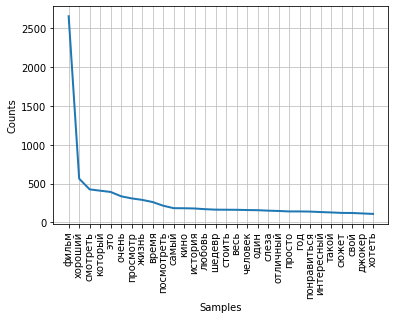

In [106]:
fdist.plot(30,cumulative=False)

### Визуализация популярности слов

In [31]:
# !pip install wordcloud
#!pip3 install Pillow==10.1.0
from wordcloud import WordCloud

In [24]:
text_raw = " ".join(text)

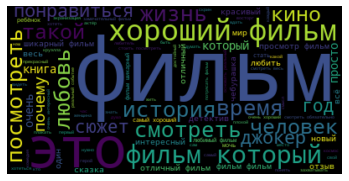

In [30]:
wordcloud = WordCloud().generate(text_raw)
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

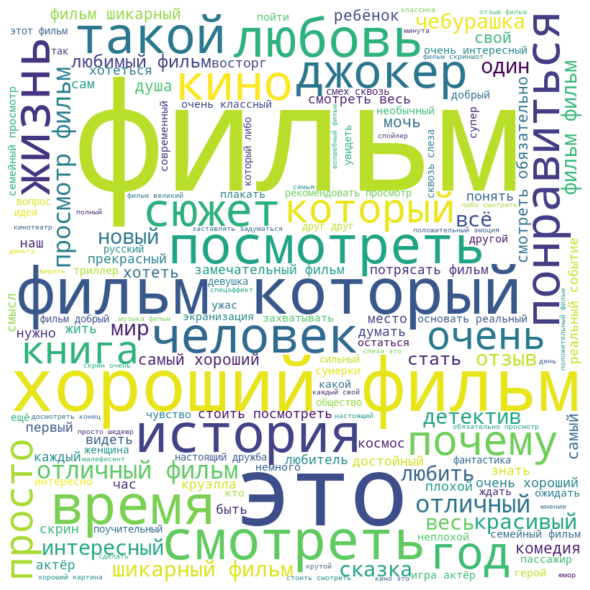

In [34]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(text_raw)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Выводы

Была проделана работа по парсигу отзывово и проведена предобработка и нормализация слов.
Как и ожидалось в отзывах о фильмах самими популярными оказались слова: фильм, кино, время, посмотреть, история, жизнь и т.д.
Для подсчета статистики и визуализации популярнсти слов были отброшены смайлики, но они понадобяться при обучении, так они хорошо характеризуют эмоциональный контекст отзывов. 